In [15]:
from PIL import Image
from sklearn import svm
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import collections
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd

In [16]:
Airlines = pd.read_csv('Airlines.csv')

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [18]:
Airlines['negativereason_gold'].value_counts()

Customer Service Issue                      12
Late Flight                                  4
Can't Tell                                   3
Cancelled Flight                             3
Cancelled Flight\nCustomer Service Issue     2
Late Flight\nFlight Attendant Complaints     1
Late Flight\nLost Luggage                    1
Bad Flight                                   1
Lost Luggage\nDamaged Luggage                1
Late Flight\nCancelled Flight                1
Flight Attendant Complaints                  1
Customer Service Issue\nLost Luggage         1
Customer Service Issue\nCan't Tell           1
Name: negativereason_gold, dtype: int64

In [19]:
Airlines['airline_sentiment_gold'].value_counts()

negative    32
positive     5
neutral      3
Name: airline_sentiment_gold, dtype: int64

In [20]:
Airlines['retweet_count'].value_counts()

0     13873
1       640
2        66
3        22
4        17
5         5
7         3
6         3
22        2
8         1
32        1
28        1
9         1
18        1
11        1
31        1
15        1
44        1
Name: retweet_count, dtype: int64

In [21]:
Airlines['tweet_coord'].value_counts()

[0.0, 0.0]                      164
[40.64656067, -73.78334045]       6
[32.91792297, -97.00367737]       3
[40.64646912, -73.79133606]       3
[35.22643463, -80.93879965]       2
                               ... 
[40.69429232, -74.17208436]       1
[37.61833841, -122.38389799]      1
[37.61859126, -122.38385699]      1
[45.58931882, -122.5959928]       1
[40.64946781, -73.76624703]       1
Name: tweet_coord, Length: 832, dtype: int64

In [22]:
Airlines.drop('negativereason_gold', axis=1, inplace=True)
Airlines.drop('airline_sentiment_gold', axis=1, inplace=True)
Airlines.drop('retweet_count', axis=1, inplace=True)
Airlines.drop('tweet_coord', axis=1, inplace=True)

Airlines.drop('tweet_location', axis=1, inplace=True)
Airlines.drop('tweet_created', axis=1, inplace=True)
Airlines.drop('user_timezone', axis=1, inplace=True)
Airlines.drop('name', axis=1, inplace=True)
#tweets.drop('',axis=1, inplace=True)

# Check the current list of columns
list(Airlines.columns)

['tweet_id',
 'airline_sentiment',
 'airline_sentiment_confidence',
 'negativereason',
 'negativereason_confidence',
 'airline',
 'text']

In [23]:
unmeaningful = ['i', 'you', 'me', 'to', 'the', 'a', 'my', 'is', 'in', 'and', 'for', 'on', 'of', 
                'your', 'so', 'was', 'have', 'it', 'at', 'with', 'that', 'from', 'do', 'get', 
                'but', 'this', 'can', 'just', 'they', 'we', 'are', 'an', 'be', "i'm", 'will', 
                'if', 'had', 'our', 'about', 'there', 'has', 'been', '-', 'by', 'like', 'or', 
                'as', 'he', 'she', 'it', 'us', 'has' ,"i've", "it's", "don't", 'would', 'am',
               'flight', 'customer', 'any', 'very', "didn't", "you've", 'thing', 'take',
               'other', 'u', '', ' ']

In [24]:
def clean_text(str_in):
    """Remove special characters, @airline/username, empty string and
    unmeaningful words from the original text.

    Args:
        str_in: A string representing a Tweet.

    Returns:
        A string similar to the input string, but it does not have
        special characters, @airline, empty word, or any unmeaningful
        words listed above. For example:

        "thanks"
    """
    res = ""
    str_in = str_in.lower()
    str_arr = str_in.split(' ')
    for word in str_arr:
        # make all words into lower case
        word = word.lower()
        # remove not useful words from the original text
        if '@' in word or word == '' or word[:1] == '&':
            continue
        if word.lower() in unmeaningful:
            continue
        if word.isnumeric():
            continue
        res = res + " " + word
    return res

In [25]:
Airlines["text"] = Airlines["text"].apply(clean_text)

In [26]:
Airlines.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,text
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,what said.
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,plus added commercials experience... tacky.
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,today... must mean need another trip!
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,"really aggressive blast obnoxious ""entertainm..."
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,really big bad


In [28]:
#### Data Analysis


In [29]:
sentiments = Airlines['airline_sentiment'].unique()
#here we know there are 3 types only 
sentiments

array(['neutral', 'positive', 'negative'], dtype=object)

In [30]:
total_negative = Airlines[Airlines['airline_sentiment'] == 'negative']['airline_sentiment_confidence'].sum()
total_positive = Airlines[Airlines['airline_sentiment'] == 'positive']['airline_sentiment_confidence'].sum()
total_neutral = Airlines[Airlines['airline_sentiment'] == 'neutral']['airline_sentiment_confidence'].sum()

values = [total_neutral, total_positive, total_negative]
dictionary1 = {'Airline Sentiment':sentiments, 'Count':values} 

dfSentimentCount = pd.DataFrame(dictionary1)
dfSentimentCount.head(3)


,Airline Sentiment,Count
0,neutral,2551.4171
1,positive,2060.6280
2,negative,8566.4269


In [32]:
######### DATA VISAULIZATION

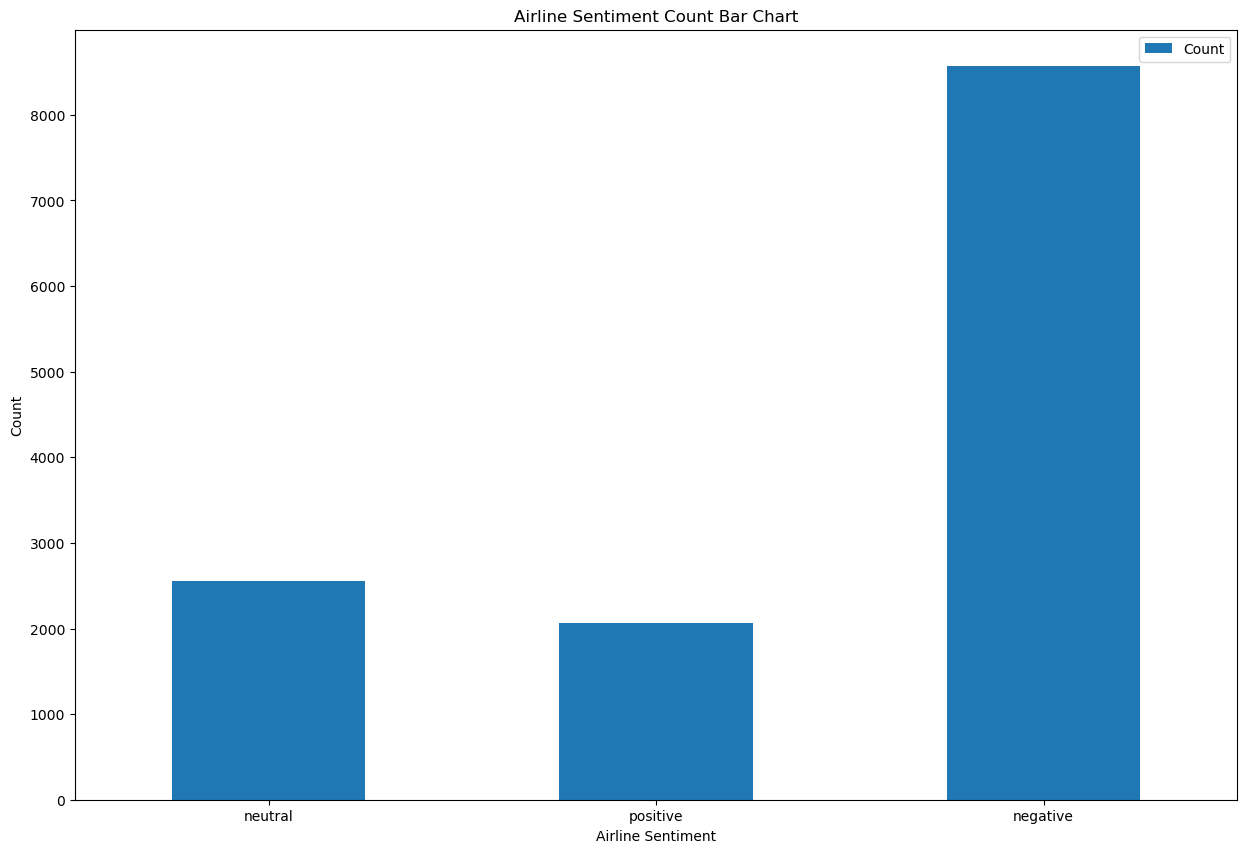

In [33]:
temp = dfSentimentCount.plot.bar(x='Airline Sentiment', y='Count', rot=0, figsize=(15,10))

# Add title and axis names
plt.title('Airline Sentiment Count Bar Chart')
plt.xlabel('Airline Sentiment')
plt.ylabel('Count')
 
# Show graphic
plt.show()

In [34]:
listOfAirlines = Airlines['airline'].unique()
listOfAirlines

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

In [36]:
neutralCount = []
positiveCount = []
negativeCount = []
totalCount = []

for airline in listOfAirlines:
    neuC = Airlines.query("airline == @airline and airline_sentiment == 'neutral'")['airline_sentiment_confidence'].sum()
    posC = Airlines.query("airline == @airline and airline_sentiment == 'positive'")['airline_sentiment_confidence'].sum()
    negC = Airlines.query("airline == @airline and airline_sentiment == 'negative'")['airline_sentiment_confidence'].sum()
    tot = neuC + posC + negC
    neutralCount.append(neuC)
    positiveCount.append(posC)
    negativeCount.append(negC)
    totalCount.append(tot)

df2 = pd.DataFrame(index=listOfAirlines);
df2['Neutral Count'] = neutralCount
df2['Positive Count'] = positiveCount
df2['Negative Count'] = negativeCount
df2

,Neutral Count,Positive Count,Negative Count
Virgin America,143.3610,134.9727,163.2137
United,564.4000,421.1578,2457.5967
Southwest,548.5365,505.0800,1091.7521
Delta,599.5580,471.7084,861.6031
US Airways,313.1524,231.2555,2140.1501
American,382.4092,296.4536,1852.1112


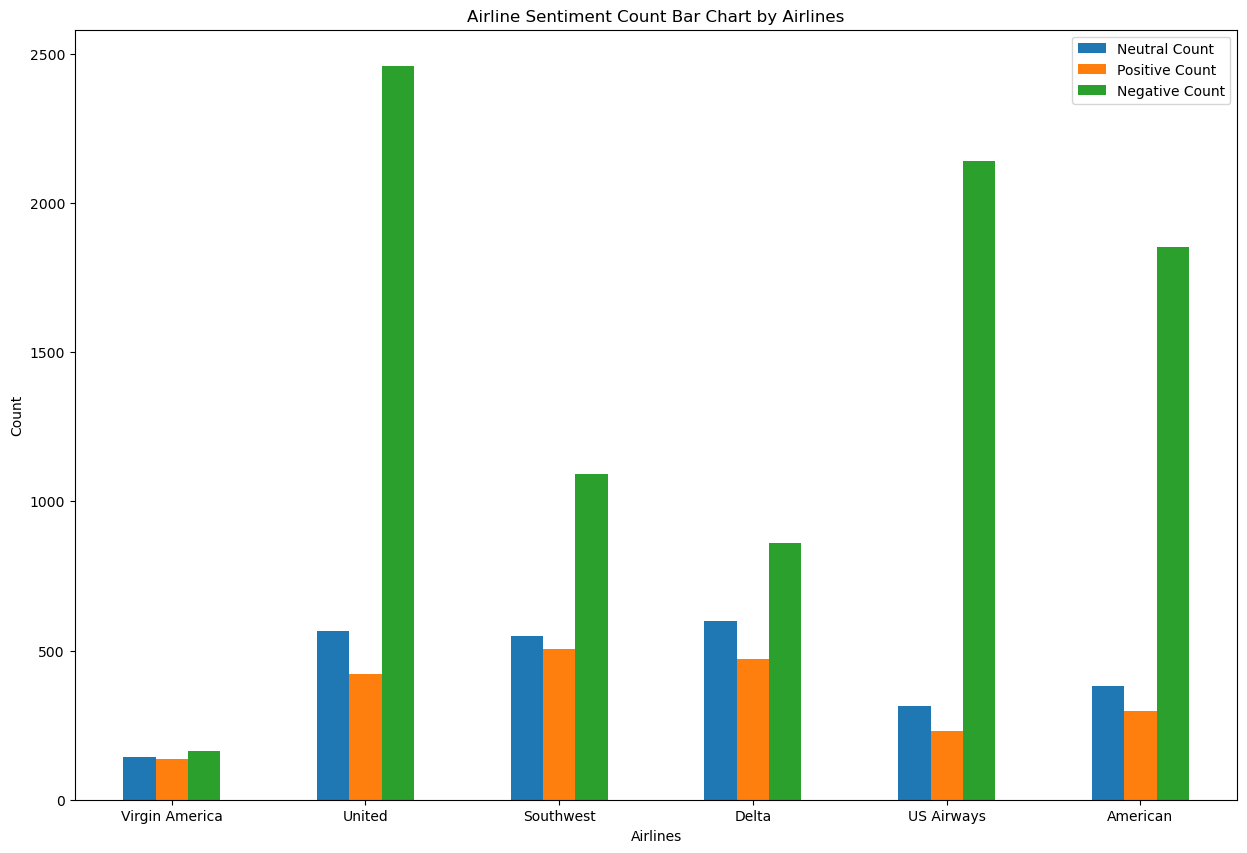

In [37]:
plt2 = df2.plot.bar(rot=0, figsize=(15,10))

# Add title and axis names
plt.title('Airline Sentiment Count Bar Chart by Airlines')
plt.xlabel('Airlines')
plt.ylabel('Count')
 
# Show graphic
plt.show()

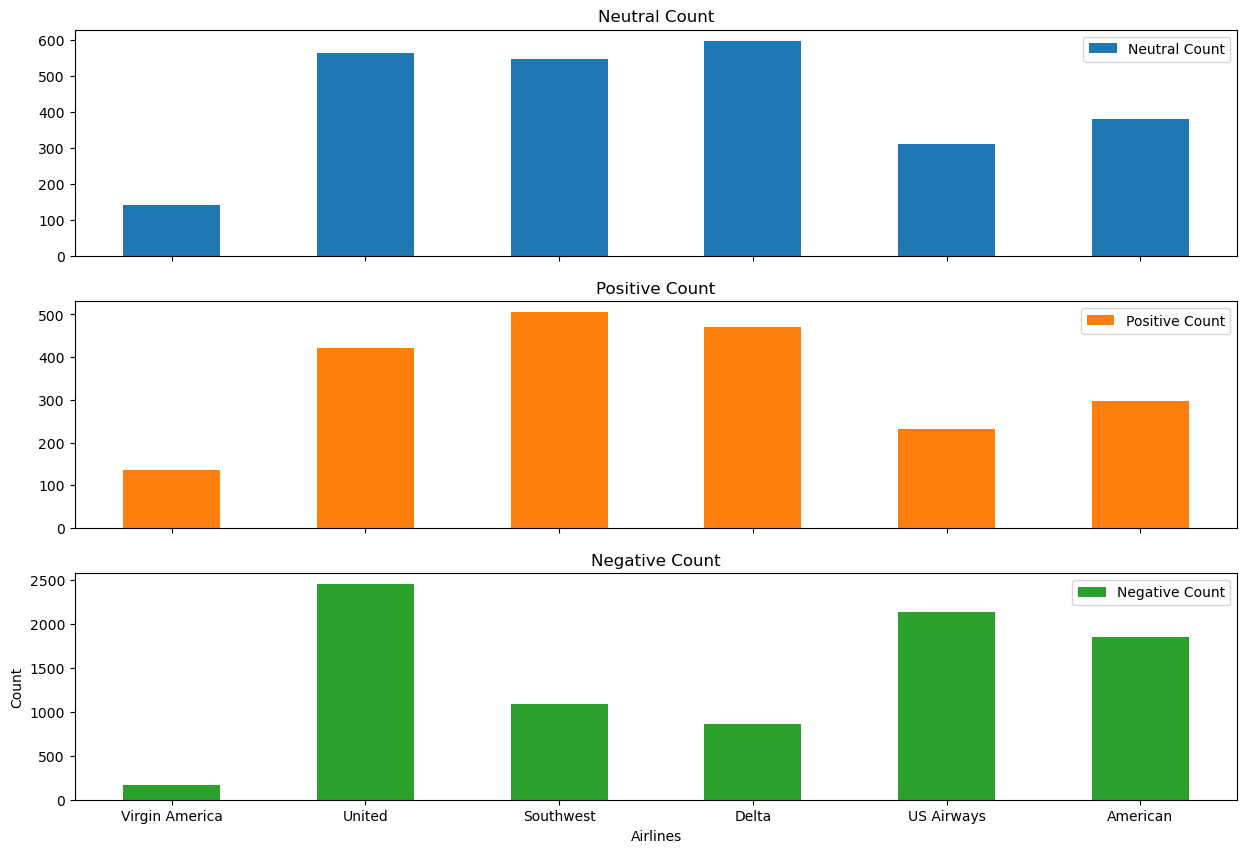

In [38]:
plt3 = df2.plot.bar(rot=0, subplots=True, figsize=(15,10))

# Add axis names
plt.xlabel('Airlines')
plt.ylabel('Count')
 
# Show graphic
plt.show()


In [39]:
percentNeg = []
for neg, tot in zip(negativeCount, totalCount):
    perc = neg/tot
    percentNeg.append(perc)
    
df3 = pd.DataFrame(index=listOfAirlines)
df3['Negative Feedback %'] = percentNeg
df3


,Negative Feedback %
Virgin America,0.369640
United,0.713763
Southwest,0.508888
Delta,0.445764
US Airways,0.797208
American,0.731778


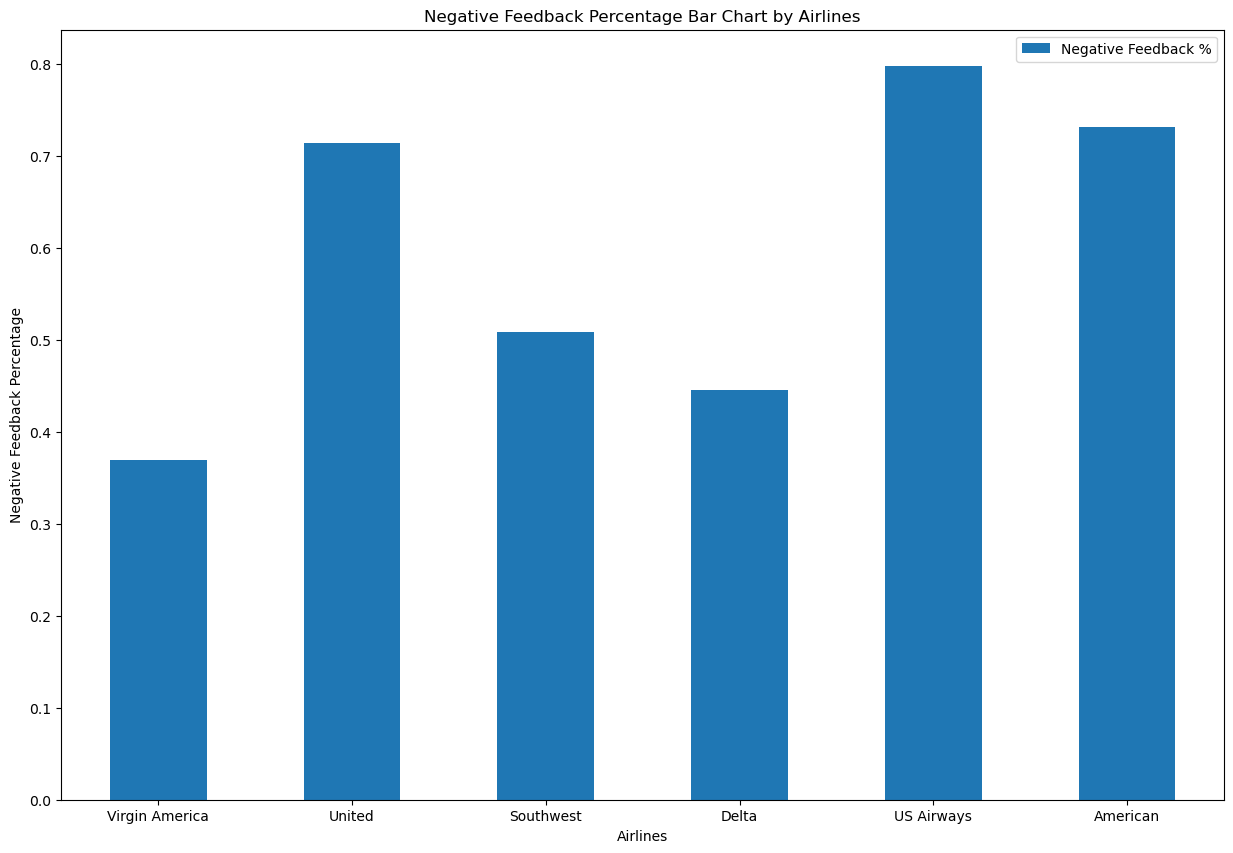

In [40]:
plt4 = df3.plot.bar(rot=0, figsize=(15,10))

# Add axis names
plt.title('Negative Feedback Percentage Bar Chart by Airlines')
plt.xlabel('Airlines')
plt.ylabel('Negative Feedback Percentage')
 
# Show graphic
plt.show()

In [44]:
negative_text = Airlines[Airlines['airline_sentiment'] == 'negative']['text']
neutral_text = Airlines[Airlines['airline_sentiment'] == 'neutral']['text']
positive_text = Airlines[Airlines['airline_sentiment'] == 'positive']['text']

In [47]:
def count_words(texts):
    """Count word frequency from the words in input list.

    Count word frequency for all the words in the input string list,
    excluding empty string.

    Args:
        texts: A list of Tweets, which is also a list of strings.

    Returns:
        A dict mapping words to the corresponding frequency in 
        the texts input list. For example:

        {'not': 1271,
         'no': 1213,
         'cancelled': 911}
         
        If the word is not existed in the texts input list, then that
        frequency cannot be found in the returning dict.
    """
    result = {}
    for text in texts:
        text_arr = text.split(' ')
        for word in text_arr:
            # exclude empty string
            if word == '':
                continue
            # increase the frequency count in the returning dict
            if word in result:
                count = result[word]
                result[word] = count + 1
            else:
                result[word] = 1
    return result

In [48]:
negative_dict = count_words(negative_text)
neutral_dict = count_words(neutral_text)
positive_dict = count_words(positive_text)

In [49]:
sorted_negative_dict = sorted(negative_dict.items(), key=operator.itemgetter(1), reverse=True)
sorted_neutral_dict = sorted(neutral_dict.items(), key=operator.itemgetter(1), reverse=True)
sorted_positive_dict = sorted(positive_dict.items(), key=operator.itemgetter(1), reverse=True)

In [50]:
negative_df = pd.DataFrame(sorted_negative_dict, columns=['Word', 'Frequency'])
negative_df


,Word,Frequency
0,not,1271
1,no,1213
2,cancelled,911
3,now,643
4,service,541
...,...,...
18003,answers!,1
18004,"play,",1
18005,delays👌,1
18006,phones!,1


In [51]:
neutral_df = pd.DataFrame(sorted_neutral_dict, columns=['Word', 'Frequency'])
neutral_df

,Word,Frequency
0,need,159
1,please,146
2,how,141
3,what,140
4,when,136
...,...,...
8161,share.,1
8162,"george,",1
8163,process:,1
8164,http://t.co/4gr39s91dl”😂,1


In [52]:
positive_df = pd.DataFrame(sorted_positive_dict, columns=['Word', 'Frequency'])
positive_df

,Word,Frequency
0,thank,452
1,thanks,397
2,great,193
3,you!,134
4,love,119
...,...,...
6362,http://t.co/drw08djhai,1
6363,relations,1
6364,concerns,1
6365,"directly,",1


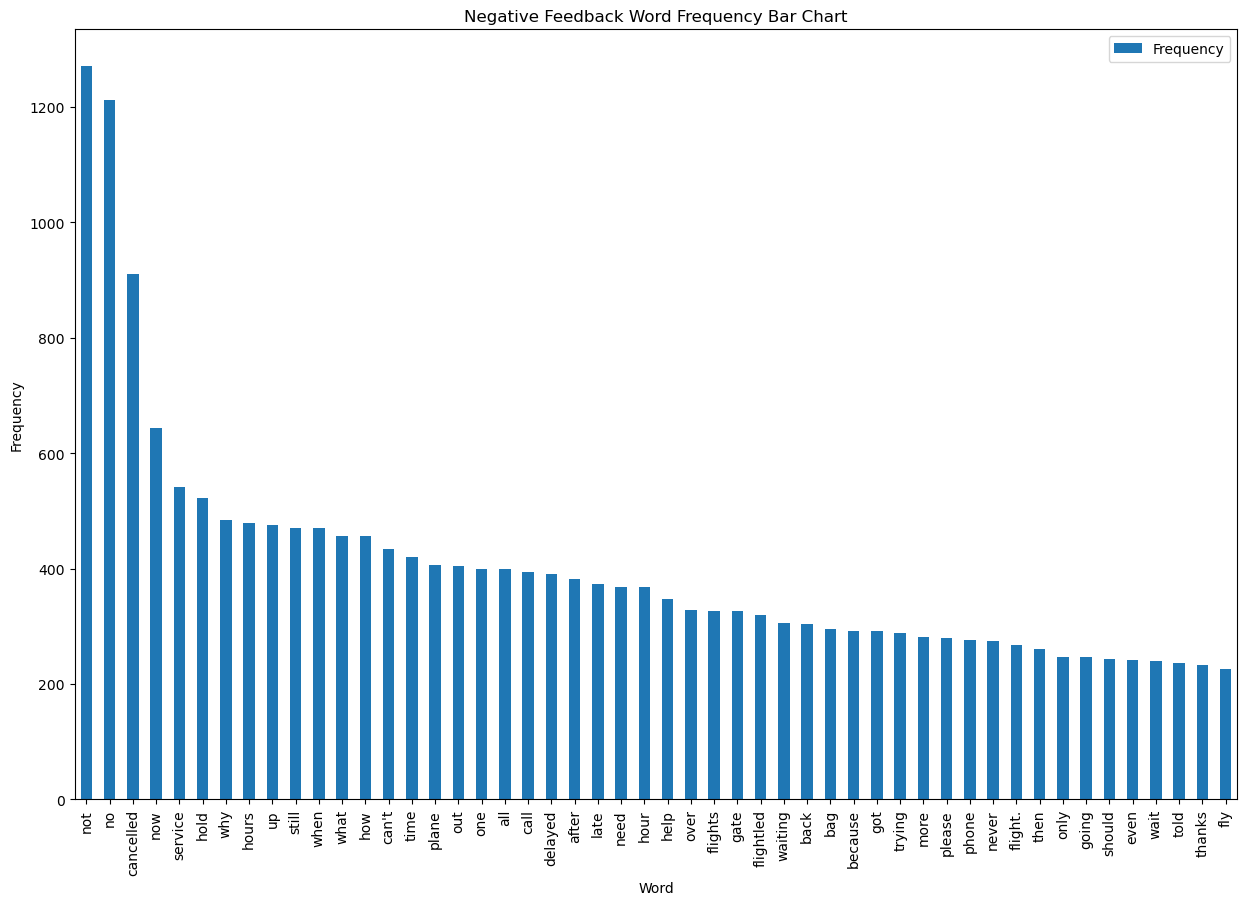

In [53]:
negative_df.set_index('Word')
plt5 = negative_df.head(50).plot.bar(x='Word', y='Frequency', figsize=(15,10))

# Add title and axis names
plt.title('Negative Feedback Word Frequency Bar Chart')
plt.xlabel('Word')
plt.ylabel('Frequency')
 
# Show graphic
plt.show()

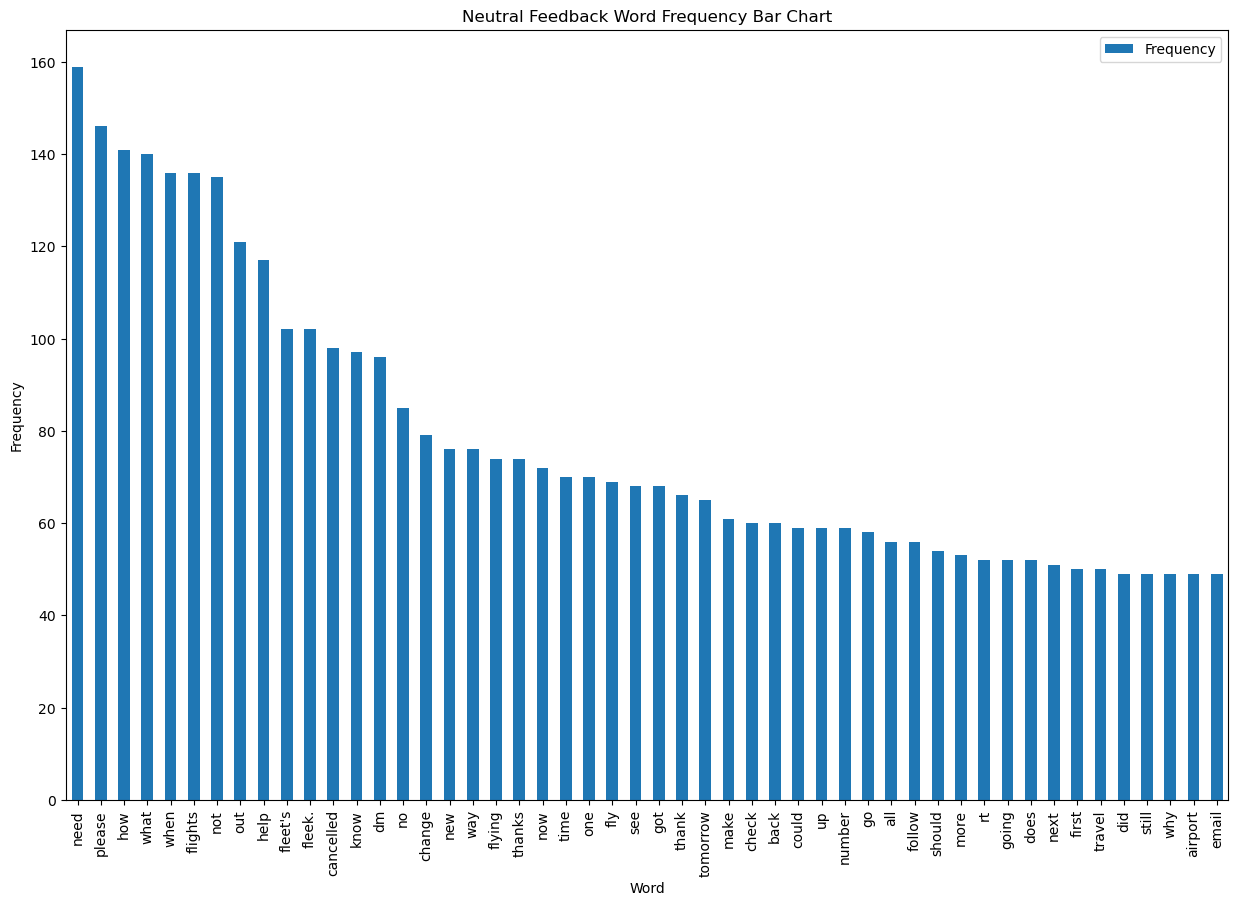

In [54]:
neutral_df.set_index('Word')
plt6 = neutral_df.head(50).plot.bar(x='Word', y='Frequency', figsize=(15,10))

# Add title and axis names
plt.title('Neutral Feedback Word Frequency Bar Chart')
plt.xlabel('Word')
plt.ylabel('Frequency')
 
# Show graphic
plt.show()

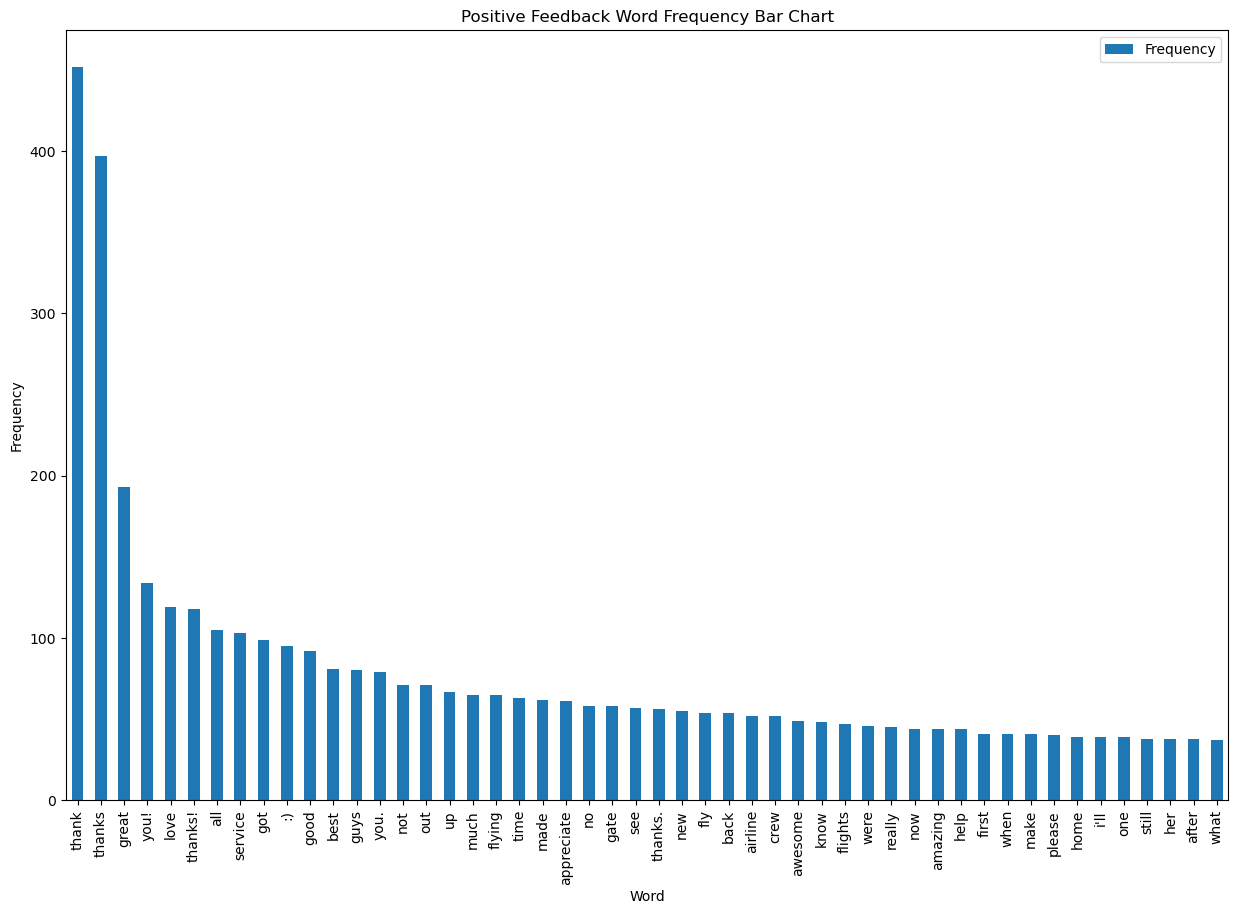

In [55]:
positive_df.set_index('Word')
plt7 = positive_df.head(50).plot.bar(x='Word', y='Frequency', figsize=(15,10))

# Add title and axis names
plt.title('Positive Feedback Word Frequency Bar Chart')
plt.xlabel('Word')
plt.ylabel('Frequency')
 
# Show graphic
plt.show()

Wordcloud for Word Frequency from all Negative Feedback


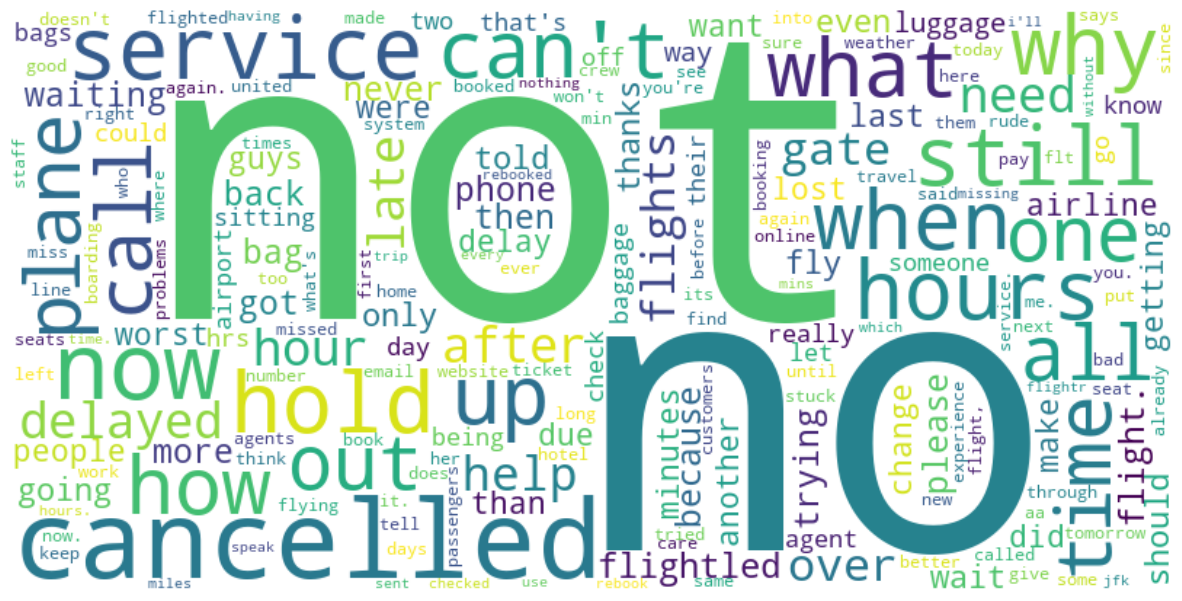

In [56]:
print("Wordcloud for Word Frequency from all Negative Feedback")

negative_wordcloud = WordCloud(background_color="white", width=800, height=400)
negative_wordcloud.generate_from_frequencies(negative_dict)
plt.figure(figsize=(15,10))
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [57]:
np.array(negative_wordcloud).shape

(400, 800, 3)

Wordcloud for Word Frequency from all Neutral Feedback


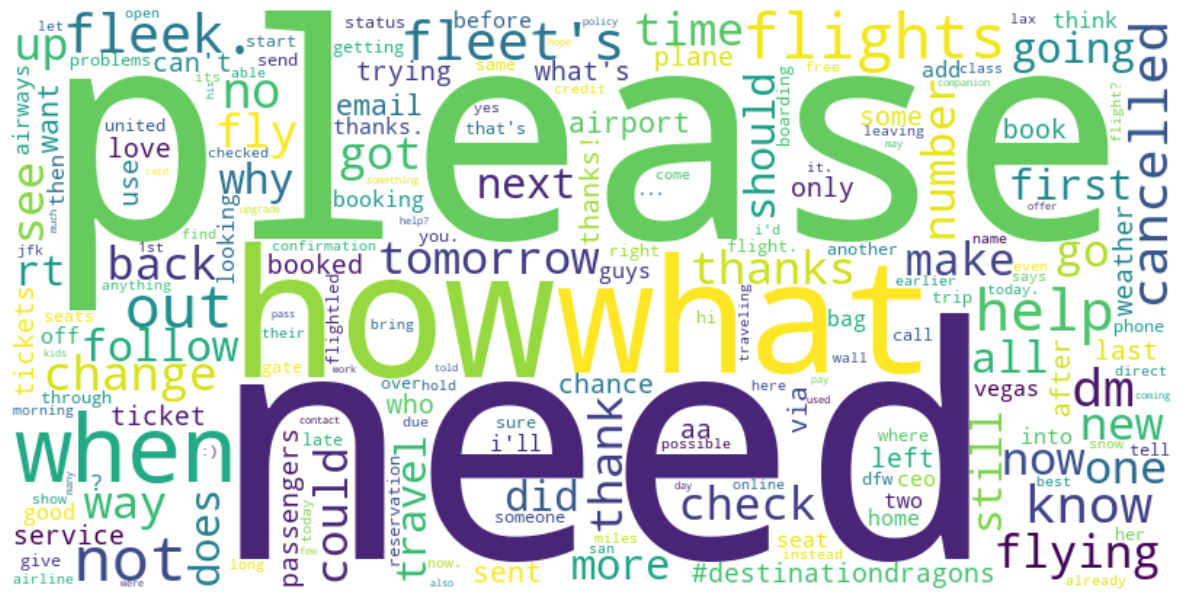

In [58]:
print("Wordcloud for Word Frequency from all Neutral Feedback")

neutral_wordcloud = WordCloud(background_color="white", width=800, height=400)
neutral_wordcloud.generate_from_frequencies(neutral_dict)
plt.figure(figsize=(15,10))
plt.imshow(neutral_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Wordcloud for Word Frequency from all Positive Feedback


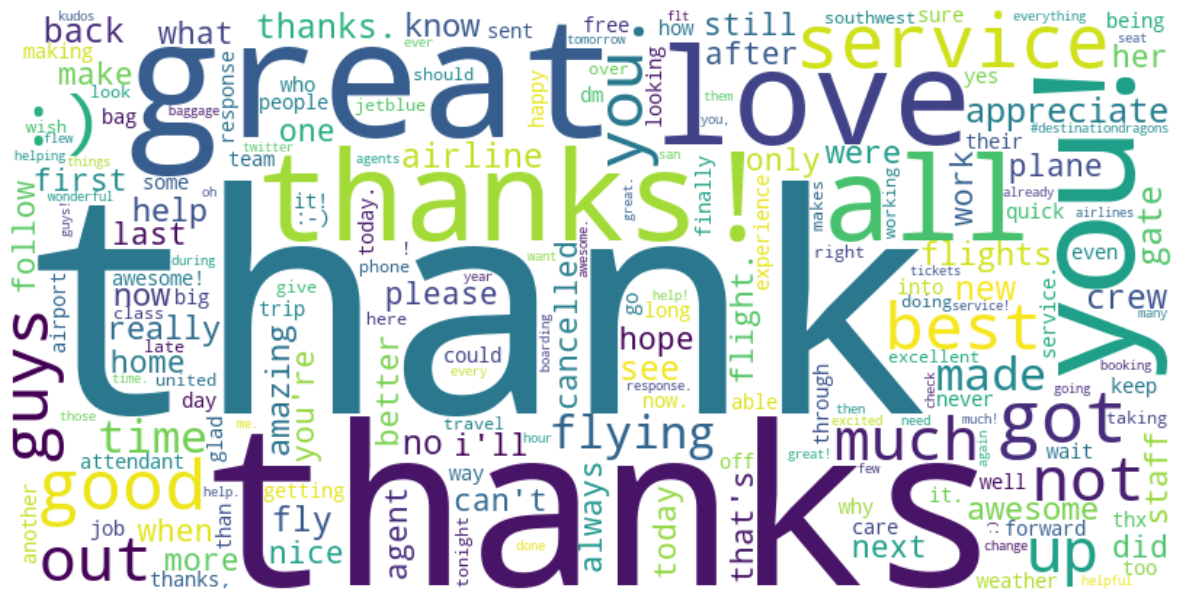

In [59]:
print("Wordcloud for Word Frequency from all Positive Feedback")

positive_wordcloud = WordCloud(background_color="white", width=800, height=400)
positive_wordcloud.generate_from_frequencies(positive_dict)
plt.figure(figsize=(15,10))
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [62]:
X_train = Airlines.loc[:11711, 'text'].values
Y_train = Airlines.loc[:11711, 'airline_sentiment'].values
X_test = Airlines.loc[11712:, 'text'].values
Y_test = Airlines.loc[11712:, 'airline_sentiment'].values

In [63]:
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

print("The shape of train vector is", train_vectors.shape)
print("The shape of test vector is", test_vectors.shape)

The shape of train vector is (11712, 12249)
The shape of test vector is (2928, 12249)


In [64]:
svc = svm.SVC()
clf = svc.fit(train_vectors, Y_train)

In [65]:
predicted = clf.predict(test_vectors)
print("Predicted result:", predicted)
print("Accuracy score from linear SVC model:", accuracy_score(Y_test, predicted))

Predicted result: ['negative' 'negative' 'positive' ... 'neutral' 'negative' 'negative']
Accuracy score from linear SVC model: 0.8159153005464481


In [66]:
nb = MultinomialNB()
clf2 = nb.fit(train_vectors, Y_train)

In [67]:
predicted2 = clf2.predict(test_vectors)
print("Predicted result:", predicted2)
print("Accuracy score from Naive Bayes model:", accuracy_score(Y_test, predicted2))

Predicted result: ['negative' 'negative' 'neutral' ... 'negative' 'negative' 'negative']
Accuracy score from Naive Bayes model: 0.7506830601092896
